# Gene target analysis

Cell factory engineering strategies can be used to improve the production of progesterone in our modelled S. cerevisiae strain (iMM904_progesterone.xml).

We investigate if gene knockouts suggested in literature actually have an improving effect on the production of progesterone, and if it would be appropiate to incorporate these gene knockouts in our model. 

Using OptGene from cameo, we investigate if there are other potential gene knockout strategies that could be used to improve the production of progesterone.

Finally, we perform flux scanning based enforced objective flux (FSEOF) analysis to investigate reactions that are significantly up- or down-regulated as a result of an enhanced flux towards progesterone. This analysis reveals up- and downregulation targets. 

In [2]:
# Load libraries
from cobra.io import read_sbml_model
from cameo.strain_design import OptGene
from cameo.strain_design.deterministic.flux_variability_based import FSEOF
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

### Knockout analysis

It has been suggested to knockout ERG5 and ERG6 in order to drive the flux towards the production of cholesterol instead of the natural produced steriod ergosterol (Figure 1) (Jiang, Yi-qi, and Jian-ping Lin 2022). It is from zymosterol, the knockouts should improve the flux towards cholesterol. It might improve the production of progesterone because cholesterol is an intermediate in the implemented heterologous pathway. However, it can be problematic to knockout ERG5 and ERG6 because ergosterol is an essential compound in the cellular membrane of S. cerevisiae (Jordá, Tania, and Sergi Puig 2020).

![figures/3_Fig1_Steriods_ERG5_ERG6.png](figures/3_Fig1_Steriods_ERG5_ERG6.png)

Figure 1 (Jiang, Yi-qi, and Jian-ping Lin 2022)

A Synthesis of steroids. Solid arrows represent reactions validated in yeast, and dashed arrows implicate conversions catalyzed by 
unknown enzyme(s). The endogenous ergosterol pathway in yeast is highlighted in blue. The three different sheds of blue represented three modules: mevalonate (MVA) biosynthesis, farnesyl pyrophosphate (FPP) biosynthesis and ergosterol biosynthesis. Heterologous synthesis of animal-derived steroids in yeast already or potentially is highlighted in orange. Heterologous synthesis of phytosterols already or potentially in yeast is highlighted in green. The reaction catalyzed by UV-light is highlighted in yellow and common steroids involved in biotransformation is highlighted in purple. The enzymes marked in red represent the ones that require NADPH/NADP+, and the ones that require ATP are marked in purple. 

B The numbering of steroid’s carbon skeleton

We investigate the influence it has on the cell to knockout ERG5 and ERG6.

In [51]:
# Load model
infilename = 'models/iMM904_progesterone.xml'
print(f"Loading {infilename}")
model = read_sbml_model(infilename)

Loading models/iMM904_progesterone.xml


In [52]:
# Progesterone is released from the cell
model.add_boundary(model.metabolites.get_by_id('progesterone_c'), type='demand')
print(f'Adding reaction {model.reactions.DM_progesterone_c.name}: {model.reactions.DM_progesterone_c.reaction}')

Adding reaction progesterone demand: progesterone_c --> 


In [5]:
# Knockout ERG5 and ERG6
model_ERG5_ERG6 = model.copy()
model_ERG5_ERG6.genes.YMR015C.knock_out() # ERG5 knockout implemented
model_ERG5_ERG6.genes.YML008C.knock_out() # ERG6 knockout implemented

if model_ERG5_ERG6.genes.YMR015C.functional == False:
    print("ERG5 knockout: True")
if model_ERG5_ERG6.genes.YML008C.functional == False:
    print("ERG6 knockout: True")

ERG5 knockout: True
ERG6 knockout: True


In [6]:
# ERG5 and ERG6 knockout influence on growth (default objective function)
print('Growth in model: µ =', round(model.optimize().objective_value,3))
print('Growth when ERG5 and ERG6 knocked out: µ =', round(model_ERG5_ERG6.optimize().objective_value,3))

Growth in model: µ = 0.288
Growth when ERG5 and ERG6 knocked out: µ = 0.288


In [7]:
# ERG5 and ERG6 knockout influence on progesterone production (objective set to progesterone forming reaction)
with model:
    model.objective = model.reactions.R02216
    print('Progesterone in model:', round(model.optimize().objective_value,3))

with model_ERG5_ERG6:
    model_ERG5_ERG6.objective = model_ERG5_ERG6.reactions.R02216
    print('Progesterone when ERG5 and ERG6 knocked out:', round(model_ERG5_ERG6.optimize().objective_value,3))

Progesterone in model: 0.143
Progesterone when ERG5 and ERG6 knocked out: 0.143


Surprisingly, knocking out ERG5 and ERG6 does not seem to influence the cell growth or the progesterone production. We further investigate if this is actually the case or if there is a problem in the model to take into account.

Our strategy for investigating this:
1. Be sure that the knockout function work as intended
2. Confirm that knocking out ERG5 and ERG6 has an influence on some reactions
3. Go through the ergosterol pathway in the model and verify that is coherent (a summary table is provided)

In [8]:
#1 Reaction where progesterone is formed
for reac in model.metabolites.progesterone_c.reactions:
    print(reac)

DM_progesterone_c: progesterone_c --> 
R02216: nad_c + pregnenolone_c <=> h_c + nadh_c + progesterone_c


In [9]:
#1 The gene encoding the enzyme driving the reaction where progesterone is formed
model.reactions.R02216.genes

frozenset({<Gene HSD3B at 0x7efe9f9e5970>})

In [10]:
#1 Progesterone production when knocking out the gene encoding the enzyme driving the reaction
model_3betaHSD = model.copy()
model_3betaHSD.genes.HSD3B.knock_out()

with model:
    model.objective = model.reactions.R02216
    print('Progesterone in model:', round(model.optimize().objective_value,3))

with model_3betaHSD:
    model_3betaHSD.objective = model_3betaHSD.reactions.R02216
    print('Progesterone when 3beta-HSD knocked out:', round(model_3betaHSD.optimize().objective_value,3))


Progesterone in model: 0.143
Progesterone when 3beta-HSD knocked out: 0.0


When 3beta-HSD is knocked out, there is as expected no production of progesterone. It is verified that the knockout function works as intended. 

In [32]:
#2 Investigate if the knockout of ERG5 and ERG6 influences some reactions (default objective function is growth)
fluxes = model.optimize().fluxes
fluxes_knockout = model_ERG5_ERG6.optimize().fluxes
count1 = 0
count2 = 0
for i, (flux, flux_knockout) in enumerate(zip(round(fluxes,3), round(fluxes_knockout,3))):
    if flux != flux_knockout:
        count1 = count1+1
    if flux != flux_knockout and flux-flux_knockout > 4 or flux-flux_knockout < -4:
        print(f'Reaction {fluxes.index[i]}: flux: {flux} is very different from knockout_ERG5_ERG6 flux: {flux_knockout}')
        print(model.reactions.get_by_id(fluxes.index[i]))
        count2 = count2 + 1

print('Knocking out ERG5 and ERG6 influence the flux of', count1, 'reactions')
print('Knocking out ERG5 and ERG6 has a high influence the flux of', count2, 'reactions')

Reaction ALCD2ir: flux: 0.0 is very different from knockout_ERG5_ERG6 flux: 14.302
ALCD2ir: acald_c + h_c + nadh_c --> etoh_c + nad_c
Reaction ALCD2x_copy2: flux: -15.815 is very different from knockout_ERG5_ERG6 flux: 0.0
ALCD2x_copy2: etoh_c + nad_c <=> acald_c + h_c + nadh_c
Reaction GLUK: flux: 10.0 is very different from knockout_ERG5_ERG6 flux: 0.0
GLUK: atp_c + glc__D_c --> adp_c + g6p_B_c + h_c
Reaction G6PI: flux: -1.293 is very different from knockout_ERG5_ERG6 flux: 8.707
G6PI: g6p_c <=> g6p_B_c
Reaction FBA: flux: 0.0 is very different from knockout_ERG5_ERG6 flux: 8.925
FBA: fdp_c <=> dhap_c + g3p_c
Reaction FBA3: flux: 8.925 is very different from knockout_ERG5_ERG6 flux: 0.0
FBA3: s17bp_c <=> dhap_c + e4p_c
Reaction HEX1: flux: 0.0 is very different from knockout_ERG5_ERG6 flux: 10.0
HEX1: atp_c + glc__D_c --> adp_c + g6p_c + h_c
Reaction PFK: flux: 0.0 is very different from knockout_ERG5_ERG6 flux: 8.925
PFK: atp_c + f6p_c --> adp_c + fdp_c + h_c
Reaction PFK_3: flux: 

It is observed that knocking out ERG5 and ERG6 change the flux of 71 reactions. In 10 of these reactions, the flux difference is more than 4.

Looking at the 10 reactions with highest flux difference, it is mainly reactions influencing the glycolysis. Interestingly, the flux towards ethanol is changed from 0.0 to 14.302 meaning that the cell starts to mimic anarobic growth instead of aerobic growth. In summary, the carbohydrate metabolism is significantly changed when knocking out ERG5 and ERG6.

The ergosterol pathway in the model starting from zymosterol is investigated by checking each reaction and the gene encoding the enzyme catalyzing the given reaction (Figure 1 in comparison to our model). One example is shown below, and a summary is seen in Table 1.

In [33]:
#3 reactions where zymosterol participate
# SAM24MT is the reaction where zymosterol is converted to fecosterol
for reac in model.metabolites.zymst_c.reactions:
    print(reac)

ZYMSTAT_SC: 0.655 hdcoa_c + 0.01 hexccoa_c + 0.27 odecoa_c + 0.02 pmtcoa_c + 0.03 stcoa_c + 0.015 tdcoa_c + 0.01 zymst_c --> coa_c + 0.01 zymstest_SC_c
C3STKR2: h_c + nadph_c + zym_int2_c --> nadp_c + zymst_c
R04804: zymst_c --> cholesta724dien3betaol_c
ZYMSTESTH_SC: h2o_c + 0.01 zymstest_SC_c --> h_c + 0.02 hdca_c + 0.655 hdcea_c + 0.01 hexc_c + 0.03 ocdca_c + 0.27 ocdcea_c + 0.015 ttdca_c + 0.01 zymst_c
ZYMSTt: zymst_e <=> zymst_c
SAM24MT: amet_c + zymst_c --> ahcys_c + fecost_c + h_c
CHLSTI: amet_c + o2_c + zymst_c --> ahcys_c + ergtetrol_c + 2.0 h2o_c + h_c
R07498: h_c + nadph_c + zymst_c <=> cholesta8en3betaol_c + nadp_c
BIOMASS_SC5_notrace: 1.1348 13BDglcn_c + 0.4588 ala__L_c + 0.046 amp_c + 0.1607 arg__L_c + 0.1017 asn__L_c + 0.2975 asp__L_c + 59.276 atp_c + 0.0447 cmp_c + 0.0066 cys__L_c + 0.0036 damp_c + 0.0024 dcmp_c + 0.0024 dgmp_c + 0.0036 dtmp_c + 0.0007 ergst_c + 0.1054 gln__L_c + 0.3018 glu__L_c + 0.2904 gly_c + 0.5185 glycogen_c + 0.046 gmp_c + 59.276 h2o_c + 0.0663 his

In [34]:
#3 reactions where ERG6 participate
model.genes.YML008C

Gene identifier,YML008C
Name,ERG6
Memory address,0x07efe9fa23e50
Functional,True
In 1 reaction(s),SAM24MT


![figures/3_Fig1_Steriods_ERG5_ERG6.png](figures/Table1_ERG_pathway.png)

Table 1: Overview of ergosterol pathway in the model. Yellow background indicated that the reaction occurs in the cytoplasm and blue background indicated that the reaction happens in the ER.

All reactions in the ergosterol pathway (Figure 1) are present in the model. Next is to investigate the flux of the reactions.

FIND ud af om Ergosta-tetraen indgår andre steder.

In [39]:
# flux through ergosterol pathway when ERG5 and ERG6 are knocked out
erg_pathway = ['SAM24MT', 'C8STI', 'C5STDS', 'C22STDS', 'ERGTETROLter', 'C24STRer', 'ERGSTter']
with model_ERG5_ERG6:
    for reac in erg_pathway:
        model_ERG5_ERG6.objective = model_ERG5_ERG6.reactions.get_by_id(reac)
        print('When ERG5 and ERG6 are knocked out', reac, 'flux is', round(model_ERG5_ERG6.optimize().objective_value,3))

When ERG5 and ERG6 are knocked out SAM24MT flux is 0.0
When ERG5 and ERG6 are knocked out C8STI flux is 0.0
When ERG5 and ERG6 are knocked out C5STDS flux is 0.0
When ERG5 and ERG6 are knocked out C22STDS flux is 0.0
When ERG5 and ERG6 are knocked out ERGTETROLter flux is 0.182
When ERG5 and ERG6 are knocked out C24STRer flux is 0.182
When ERG5 and ERG6 are knocked out ERGSTter flux is 0.182


Flux suddenly appear in the reaction where ergosta-5,7,22,24(28)-tetraen-3b-ol diffuses from the cytoplasm into the ER. The most obvious reason would be that there is another reaction which produces ergosta-5,7,22,24(28)-tetraen-3b-ol in the cytoplasm. 

In [14]:
# what reactions does ergosta-5,7,22,24(28)-tetraen-3b-ol participate in
model.metabolites.ergtetrol_c

Metabolite identifier,ergtetrol_c
Name,Ergosta 5 7 22 24 28 tetraen 3beta ol C28H42O
Memory address,0x07f1c78782bb0
Formula,C28H42O
Compartment,c
In 4 reaction(s),"ERGTETROLter, C22STDS, C22STDSx, CHLSTI"


In [40]:
# reaction is not a part of the ergosterol pathway
model.reactions.CHLSTI

Reaction identifier,CHLSTI
Name,Cholestenol delta isomerase lumped reaction
Memory address,0x07efe9f778fa0
Stoichiometry,amet_c + o2_c + zymst_c --> ahcys_c + ergtetrol_c + 2.0 h2o_c + h_c S-Adenosyl-L-methionine + O2 O2 + Zymosterol C27H44O --> S-Adenosyl-L-homocysteine + Ergosta 5 7 22 24 28 tetraen 3beta ol C28H42O + 2.0 H2O H2O + H+
GPR,EBP
Lower bound,0.0
Upper bound,999999.0


Zymosterol is used in the above reaction for the production of ergosta-5,7,22,24(28)-tetraen-3b-ol. This is likely a reason why it does not make any change in progesterone production to knockout ERG5 and ERG6. Therefore, we try to knockout EBP on top of ERG5 and ERG6. 

In [43]:
# knock out EBP
model_ERG5_ERG6_EBP = model_ERG5_ERG6.copy()
model_ERG5_ERG6_EBP.genes.EBP.knock_out() # EBP knockout implemented

In [45]:
# flux through ergosterol pathway when ERG5, ERG6, and EBP are knocked out
erg_pathway = ['SAM24MT', 'C8STI', 'C5STDS', 'C22STDS', 'ERGTETROLter', 'C24STRer', 'ERGSTter']
with model_ERG5_ERG6_EBP:
    for reac in erg_pathway:
        model_ERG5_ERG6_EBP.objective = model_ERG5_ERG6_EBP.reactions.get_by_id(reac)
        print('When ERG5, ERG6, and EBP are knocked out', reac, 'flux is', round(model_ERG5_ERG6_EBP.optimize().objective_value,3))

When ERG5, ERG6, and EBP are knocked out SAM24MT flux is 0.0
When ERG5, ERG6, and EBP are knocked out C8STI flux is 0.0
When ERG5, ERG6, and EBP are knocked out C5STDS flux is 0.0
When ERG5, ERG6, and EBP are knocked out C22STDS flux is 0.0
When ERG5, ERG6, and EBP are knocked out ERGTETROLter flux is 0.0
When ERG5, ERG6, and EBP are knocked out C24STRer flux is 0.0
When ERG5, ERG6, and EBP are knocked out ERGSTter flux is 0.0


In [46]:
# Progesterone production
with model:
    model.objective = model.reactions.R02216
    print('Progesterone when complete model: ', round(model.optimize().objective_value,3))
with model_ERG5_ERG6:
    model_ERG5_ERG6.objective = model_ERG5_ERG6.reactions.R02216
    print('Progesterone when ERG5 and ERG6 is knocked out: ', round(model_ERG5_ERG6.optimize().objective_value,3))
with model_ERG5_ERG6_EBP:
    model_ERG5_ERG6_EBP.objective = model_ERG5_ERG6_EBP.reactions.R02216
    print('Progesterone when ERG5, ERG6, and EBP is knocked out: ', round(model_ERG5_ERG6_EBP.optimize().objective_value,3))

Progesterone when complete model:  0.143
Progesterone when ERG5 and ERG6 is knocked out:  0.143
Progesterone when ERG5, ERG6, and EBP is knocked out:  0.143


In [47]:
# Growth
print('Growth in model: µ =', round(model.optimize().objective_value,3))
print('Growth when ERG5 and ERG6 is knocked out: µ =', round(model_ERG5_ERG6.optimize().objective_value,3))
print('Growth when ERG5, ERG6, and EBP is knocked out: µ =', round(model_ERG5_ERG6_EBP.optimize().objective_value,3))

Growth in model: µ = 0.288
Growth when ERG5 and ERG6 is knocked out: µ = 0.288
Growth when ERG5, ERG6, and EBP is knocked out: µ = 0.0


Neither of the knockouts increase the production of progesterone which makes it clear that it is not appropriate engineer any of these knockouts. Besides, it is observed that knocking out ERG5, ERG6, and EBP make the cell unable to grow recalling that ergosterol is an important compound in the cellular membrane of S. cerevisiae (Jordá, Tania, and Sergi Puig 2020).

We investigate if knocking out other genes would improve the production of progesterone using OptGene from Cameo.

In [20]:
#optgene = OptGene(model)
#result = optgene.run(target=model.reactions.R02216,
 #                   biomass=model.reactions.BIOMASS_SC5_notrace, 
  #                  substrate=model.metabolites.glc__D_e, 
   #                 max_evalutations=50000, plot=False)

In [21]:
#result

The cell engineering strategy of knocking out genes does not improve the production of progesterone. It can have adverse effects on the cell to knockout genes because there is a chance that it results in significant lowered fitness properties.

### Up-regulation and down-regulation targets

We use FSEOF analysis to find targets that are up- or down-regulated as a result of an increasing flux towards the production of progesterone.

In [53]:
# Run FSEOF analysis
fseof = FSEOF(model)
result=fseof.run(target=model.reactions.R02216)
df=result.data_frame
df

,1,2,3,4,5,6,7,8,9,10
ACALDtm,-0.051995,0.000000,0.000000,0.000000,0.000000,0.000000,-0.543187,-1.100775,-1.636180,-1.602570
ACONT,0.173048,0.270551,0.254665,0.238779,0.222893,0.207007,0.191121,0.175079,0.158477,0.141874
ACtm,-0.051995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ALCD2irm,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.543187,1.100775,1.636180,1.602570
ADK1,0.762076,0.810179,0.848810,0.887440,0.926071,0.964701,1.003332,1.041586,1.078479,1.115373
...,...,...,...,...,...,...,...,...,...,...
R01456,0.012857,0.025714,0.038571,0.051429,0.064286,0.077143,0.090000,0.102857,0.115714,0.128571
ECYP11A1,0.012857,0.025714,0.038571,0.051429,0.064286,0.077143,0.090000,0.102857,0.115714,0.128571
R03353,0.012857,0.025714,0.038571,0.051429,0.064286,0.077143,0.090000,0.102857,0.115714,0.128571
R07215,0.012857,0.025714,0.038571,0.051429,0.064286,0.077143,0.090000,0.102857,0.115714,0.128571


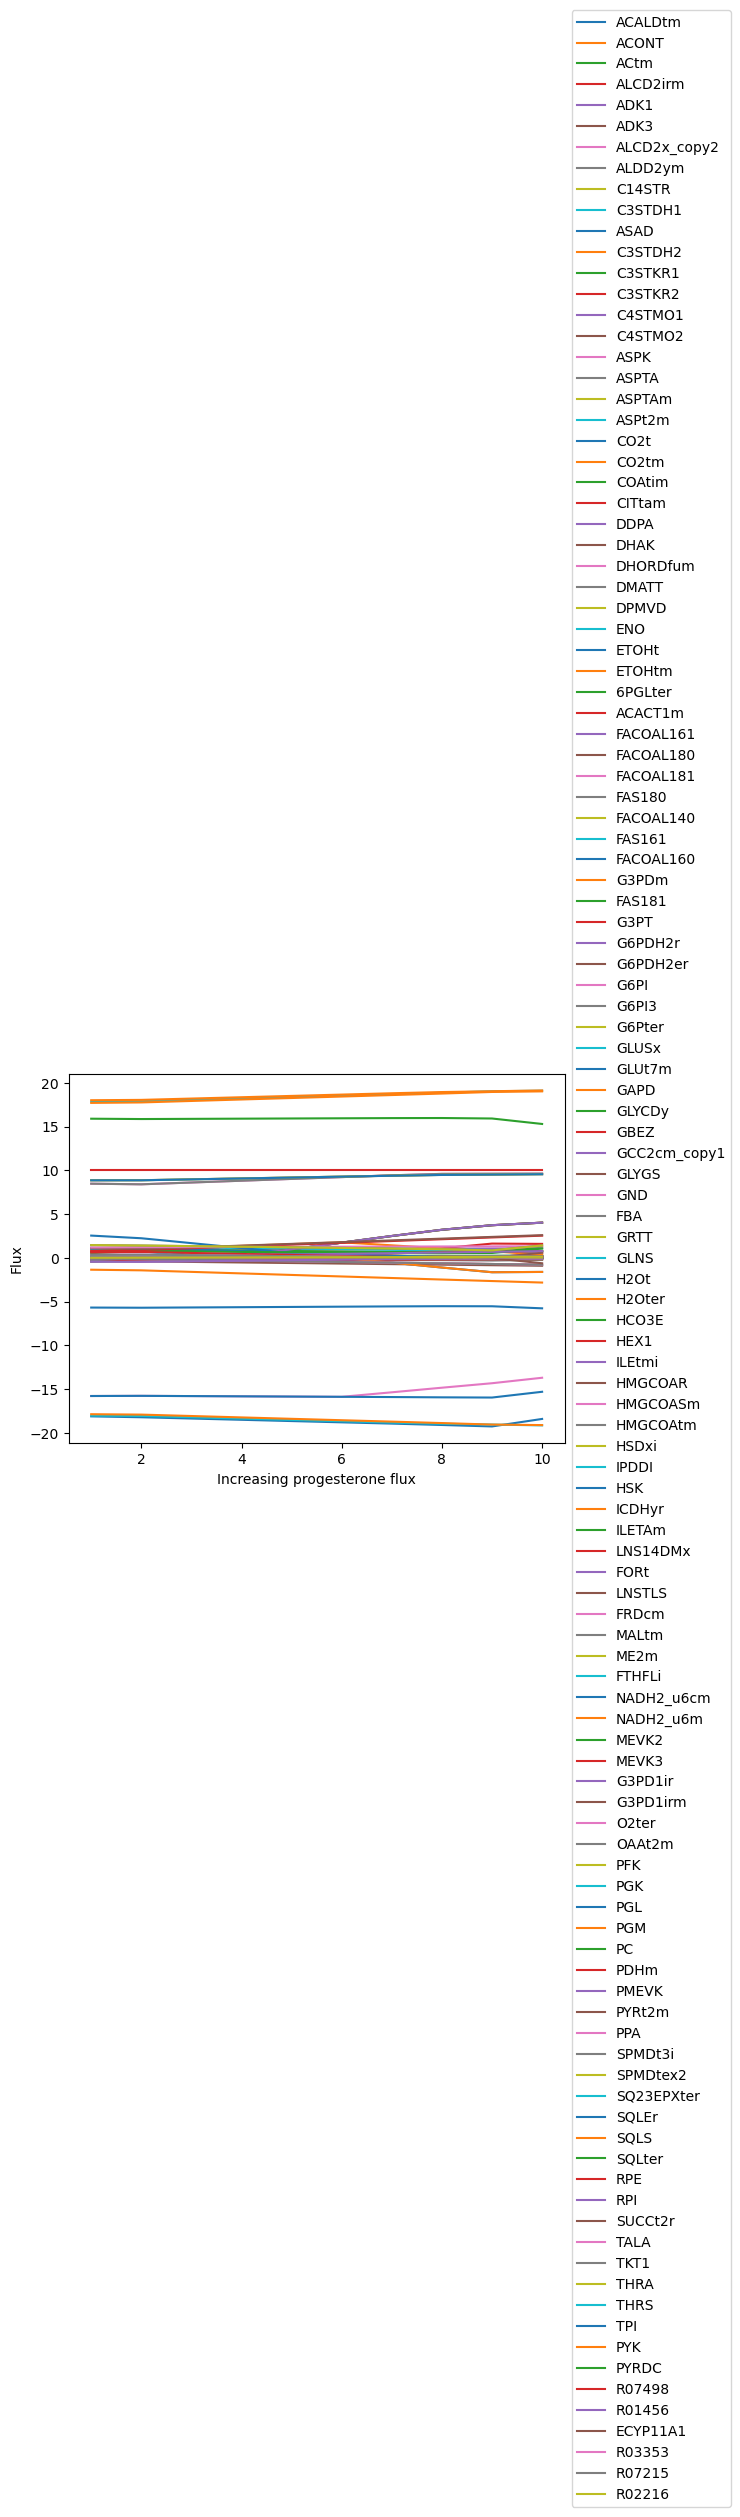

In [55]:
# plot FSEOF analysis
df.T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Increasing progesterone flux");
plt.ylabel(r"Flux");
plt.show()

In [88]:
# relative flux change
df = df.sort_values([1], ascending = False)
df['relative_change_in_flux'] = (df[10]-df[1])/df[10]
target_reactions_df = df[df['relative_change_in_flux'] > 0.9]
target_reactions_df

,1,2,3,4,5,6,7,8,9,10,relative_change_in_flux
MEVK3,0.073260,0.150568,0.227929,0.305290,0.382651,0.460012,0.537373,0.614736,0.692107,0.769478,0.904793
R03353,0.012857,0.025714,0.038571,0.051429,0.064286,0.077143,0.090000,0.102857,0.115714,0.128571,0.900001
R07498,0.012857,0.025714,0.038571,0.051429,0.064286,0.077143,0.090000,0.102857,0.115714,0.128571,0.900001
R01456,0.012857,0.025714,0.038571,0.051429,0.064286,0.077143,0.090000,0.102857,0.115714,0.128571,0.900001
ECYP11A1,0.012857,0.025714,0.038571,0.051429,0.064286,0.077143,0.090000,0.102857,0.115714,0.128571,0.900001
R07215,0.012857,0.025714,0.038571,0.051429,0.064286,0.077143,0.090000,0.102857,0.115714,0.128571,0.900001
G3PD1ir,0.006850,0.006559,0.006174,0.225148,0.985884,1.746619,2.507355,3.217920,3.738481,4.031435,0.998301
G3PDm,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003794,0.595609,1.000000
G3PD1irm,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003794,0.595609,1.000000
ALCD2irm,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.543187,1.100775,1.636180,1.602570,1.000000


Text(0.5, 1.0, 'Flux scanning based on Enforced Objective Flux')

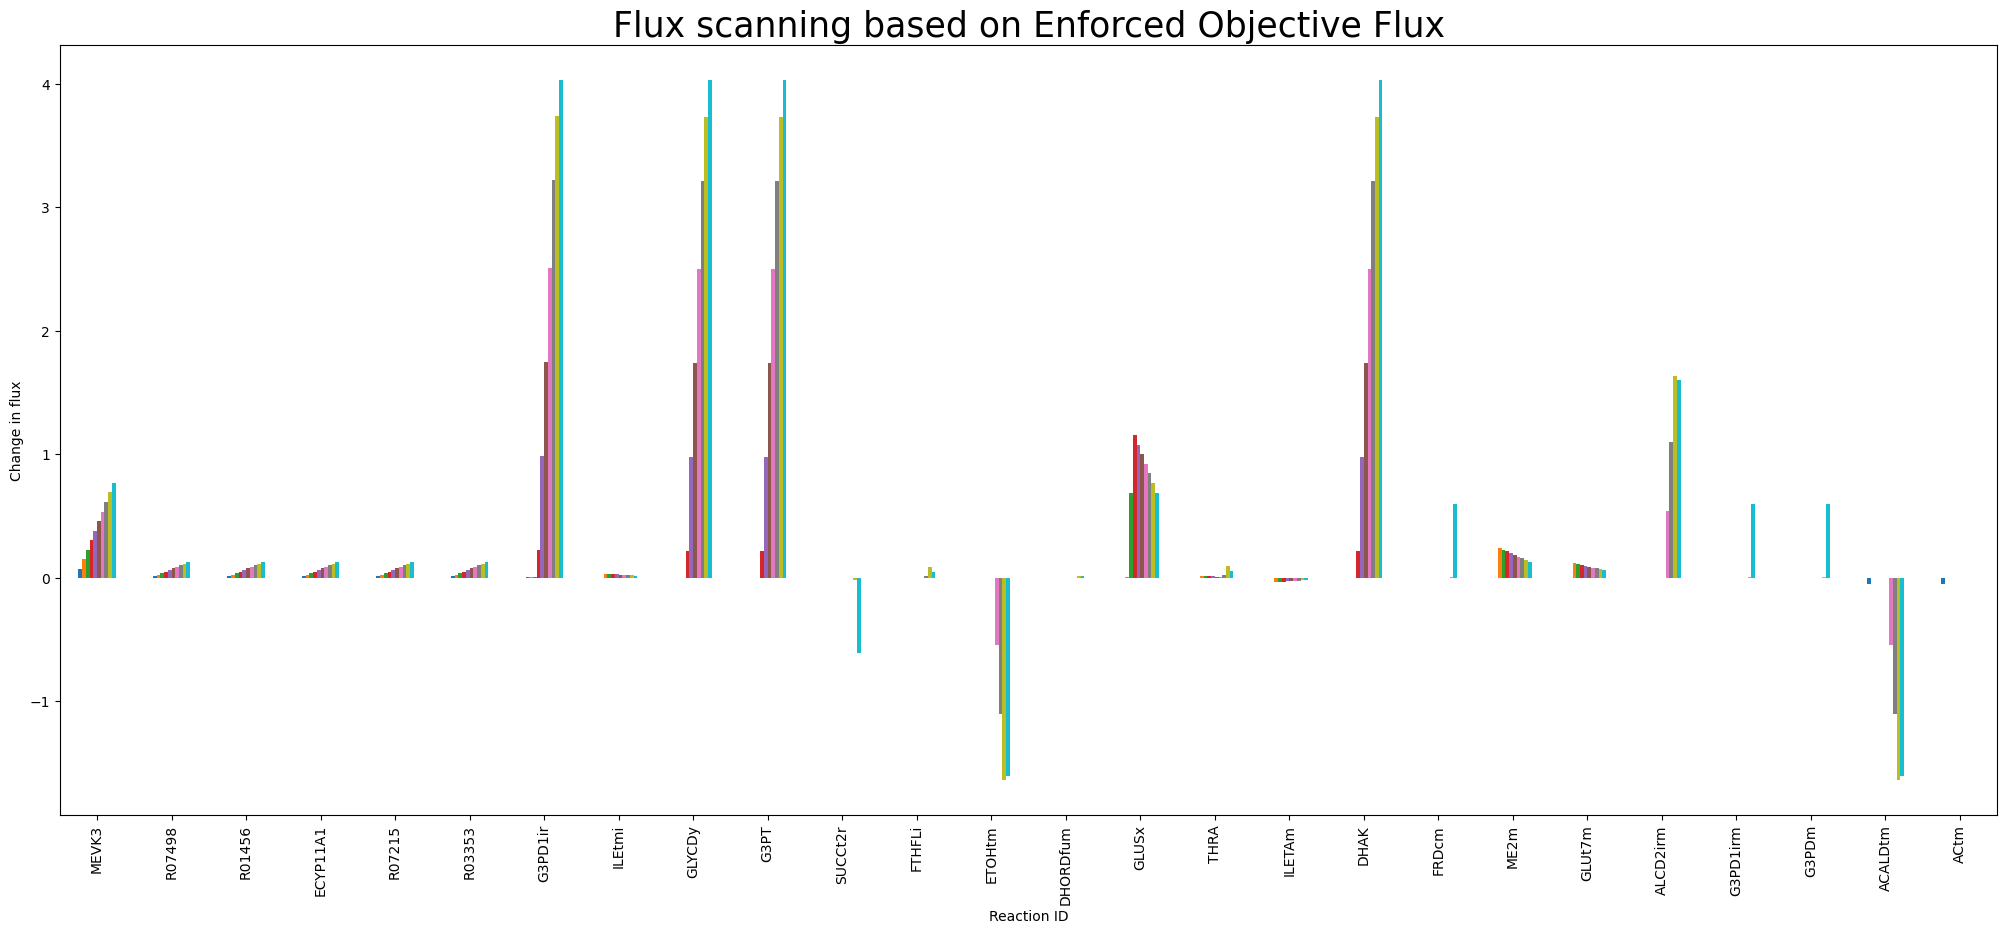

In [89]:
# plot of reactions with highest relative flux change
target_reactions_df_plot = target_reactions_df.iloc[:,:10]
target_reactions_df_plot = target_reactions_df_plot.sort_values([1], ascending = False)
fig = target_reactions_df_plot.plot(legend=None, kind='bar', figsize=(25, 10), grid =False);
fig.set_ylabel('Change in flux')
fig.set_xlabel('Reaction ID')
fig.set_title('Flux scanning based on Enforced Objective Flux', size=25)

In [90]:
for i in range(10):
    print(model.reactions.get_by_id(target_reactions_df.index.values[i]).id, model.reactions.get_by_id(target_reactions_df.index.values[i]).name)

MEVK3 Mevalonate kinase  gtp 
R03353 C-8 sterol isomerase ERG2
R07498 Delta(24)-sterol reductase
R01456 Cholesterol:NAD+ delta7-oxidoreductase
ECYP11A1 Cholesterol monooxygenase (side-chain-cleaving)
R07215 Delta(7)-sterol 5(6)-desaturase ERG3
G3PD1ir Glycerol 3 phosphate dehydrogenase  NAD 
G3PDm Glycerol 3 phosphate dehydrogenase  FAD   mitochondrial
G3PD1irm Glycerol 3 phosphate dehydrogenase  NAD   mitochondrial
ALCD2irm Alcohol dehydrogenase  reverse rxn  acetaldehyde   ethanol   mitochondrial


In [95]:
model_ERG2_overexp = model.copy()
model_ERG2_overexp = changeRxnBounds(model_ERG2_overexp, 'R03353', 50, 'l')

model.reactions.MEVK1.lower_bound

NameError: name 'changeRxnBounds' is not defined

This plot shows how the flux of a given reaction changes when the flux towards progesterone is increased. The columns from left to right within each reaction is due to an increased flux towards progesterone meaning that the relative flux change can be observed. For example, it might be more interesting to up-regulate GAPD instead of HEX1. GAPD flux increases when progesterone flux increases in constrast to HEX1 flux that remain the same.

### References
Jiang, Yi-qi, and Jian-ping Lin. "Recent progress in strategies for steroid production in yeasts." World Journal of Microbiology and Biotechnology 38.6 (2022): 1-14.

Jordá, Tania, and Sergi Puig. "Regulation of ergosterol biosynthesis in Saccharomyces cerevisiae." Genes 11.7 (2020): 795.